# Delineate basins 1-by-1
This is a working script used to delineate basins using the MERIT Hydro data (DEM, flow direction, basin discretization). CAMELS-US and RHBN metadata about station locations do not always lead to accurate basin delineation. In this script we go through the basins one by one, so that we can manually modify the outlet location in the CAMELS-spat metadata file for basins for which the original station or outlet location is not a good fit with the MERIT DEM. This also lets us add extra notes about the confidence we have in this manually moved outlet and therefore the resulting basin outline. 

Workflow:
1. Load the required data:
    1. CAMELS-spat metadata file
    2. MERIT Hydro DEM
    3. MERIT Hydro flow direction
    4. MERIT Hydro basin discretization
2. Manually loop over all catchments. For each catchment:
    1. Read the station or outlet locations
    2. Delineate basin from station/outlet location:
        1. Create a subset of the GeoTIFF files for quicker processing
        2. Delineate basin
        3. Get the appropriate MERIT Hydro shapefiles
            1. Extract the river network if it exists for this station
            2. Use the river network IDs to extract the correct basins
            3. Clip the basins to the station location
    3. Perform checks and add results to metadata file
        1. Calculate new basin area
        2. If reference area(s) exist, print a comparison
        3. If reference shapefile exists, compute overlap between reference and new shape
    4. Make a decision:
        1. If area and overlap are OK, use the current station or outlet location
        2. If no area or reference shape are available, do a manual check
        3. If area and overlap are not OK, go to file `1_manually_define_outlets` and:
            1. Update outlet location
            2. Record what changes were made and why
    5. Save new shape:
        1. As a lumped catchment discretization
        2. As a spatially-distributed discretization
3. Save the updated metadata file

In [1]:
import sys
import warnings
import pandas as pd
import geopandas as gpd
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import python_cs_functions as cs

### Config handling

In [2]:
# Specify where the config file can be found
config_file = '../0_config/config.txt'

In [3]:
# Get the required info from the config file
data_path     = cs.read_from_config(config_file,'data_path')

# CAMELS-spat metadata
cs_meta_path  = cs.read_from_config(config_file,'cs_basin_path')
cs_meta_name  = cs.read_from_config(config_file,'cs_meta_name')

# MERIT Hydro data
merit_path = cs.read_from_config(config_file, 'merit_path')
merit_acc = Path(data_path) / merit_path / 'flow_accumulation_grid' / 'merit_hydro_acc.tif'
merit_dir = Path(data_path) / merit_path / 'flow_direction_grid' / 'merit_hydro_dir.tif'
merit_bas = Path(data_path) / merit_path / 'shapes' / 'basins' / 'cat_pfaf_7_8_MERIT_Hydro_v07_Basins_v01_bugfix1_hillslopes_pfaf_7_8_clean_fixed.shp'
merit_riv = Path(data_path) / merit_path / 'shapes' / 'rivers' / 'riv_pfaf_7_8_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'

# Basin folder
cs_basin_folder = cs.read_from_config(config_file, 'cs_basin_path')

### Data loading

In [90]:
# CAMELS-spat metadata file
cs_meta_path = Path(data_path) / cs_meta_path
cs_meta = pd.read_csv(cs_meta_path / cs_meta_name)

In [5]:
# Shapefiles
basins_shp = gpd.read_file(merit_bas)
rivers_shp = gpd.read_file(merit_riv)

## DEV

In [6]:
# Create a temporary directory for subsetting files
tmp_dir = Path(data_path) / 'tmp'
tmp_dir.mkdir(parents=True, exist_ok=True)

In [7]:
ii = 0

In [8]:
# 1. Prepare file paths and names
# --------------------------------------------------------------------------------------
basin_id, shp_lump_path, shp_dist_path, ref_path, plot_path = \
    cs.prepare_delineation_outputs(cs_meta, ii, Path(data_path)/cs_basin_folder)

In [9]:
print(shp_lump_path)
print(shp_dist_path)
print(ref_path)
print(plot_path)

C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AD002\shapefiles\lumped\CAN_01AD002_lumped.shp
C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AD002\shapefiles\distributed\CAN_01AD002_distributed_{}.shp
C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AD002\shapefiles\reference\CAN_01AD002_reference.shp
C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AD002\shapefiles\CAN_01AD002_delineation_results.png


In [10]:
# 2. Get the station or outlet location
# --------------------------------------------------------------------------------------
lat,lon = cs.read_delineation_coords(cs_meta,ii)

In [11]:
print(lat,lon)

47.2577 -68.59414


In [12]:
# 3. Delineate the basin
# --------------------------------------------------------------------------------------

In [13]:
# 3a. Subset the Geotiffs for quicker processing
subset_window = cs.determine_pysheds_data_loading_window(lat,lon, str(merit_acc))
temp_acc,temp_dir = cs.subset_tifs_around_gauge(subset_window, 
                                               str(merit_acc), 
                                               str(merit_dir),
                                               temp_dir = tmp_dir)
grid,acc,fdir = cs.load_tifs_with_pysheds(str(temp_acc),str(temp_dir))

In [14]:
print(subset_window)
print(temp_acc, temp_dir)

(-83.59414, 37.2577, -53.594139999999996, 57.2577)
C:\Globus endpoint\CAMELS_spat\tmp\small_acc.tif C:\Globus endpoint\CAMELS_spat\tmp\small_fdir.tif


In [15]:
# 3b. Extract the full basin with pysheds

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore',category=FutureWarning)
    lump_basin = cs.delineate_catchment_with_pysheds(grid,lon,lat,fdir,shp_lump_path)

In [17]:
# 3c. Extract the MERIT Hydro basins and river network

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore',category=FutureWarning)
    dist_basin, dist_river = cs.subset_merit_hydro_to_basin(basins_shp, rivers_shp, lump_basin, shp_dist_path, lat, lon)

In [19]:
# 4. Delineation checks
# --------------------------------------------------------------------------------------

In [20]:
# 4a. Assert shape validity
if not all(lump_basin.is_valid): print('ERROR: Lumped shape not valid')
if not all(dist_basin.is_valid): print('ERROR: Distributed shape not valid')

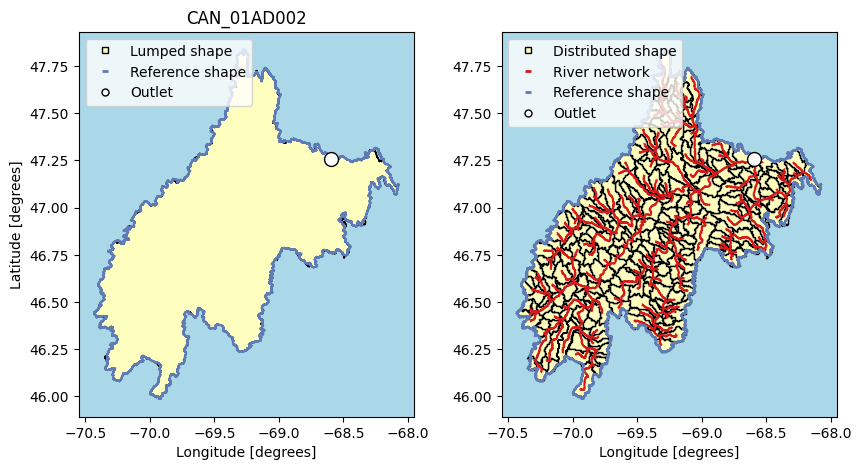

In [21]:
# 4b. Visual assessment of outcomes
cs.plot_discretization_results(basin_id, lump_basin, dist_basin, dist_river, ref_path, lat, lon, plot_path)

In [42]:
# 4c. Area and overlap
overlap_lump = cs.calculate_basin_and_reference_overlap(lump_basin, ref_path) # Returns 'n/a' if no reference shape exists
overlap_dist = cs.calculate_basin_and_reference_overlap(dist_basin, ref_path) # Should be identical to lumped, but good to check

In [43]:
print(overlap_lump, overlap_dist)

0.9947814303843993 0.9947814303843993


In [96]:
area_lump = (lump_basin.to_crs('ESRI:102008').area / 10**6)[0] # [km^2]
area_dist = dist_basin['unitarea'].sum() # [km^2]

In [97]:
print(area_lump,area_dist)

14691.618875983753 14691.618938656178


In [82]:
ref_areas = cs.get_reference_areas(cs_meta,ii) # [km^2]

In [83]:
print(ref_areas)

{'HYDAT gross drainage area': 14700.0, 'HYDAT effective drainage area': nan, 'WSC 2022 data set': 14677.4}


In [ ]:
# 4d. Update metadata file
cs_meta.iat[ii,c_area] = area_dist
cs_meta.iat[ii,c_lump_overlap] = overlap_lump
cs_meta.iat[ii,c_dist_overlap] = overlap_dist

In [84]:
def get_reference_areas(df,i):
    
    '''Reads reference areas from metadata file
    
    Input:
    - df: dataframe with CAMELS-spat metadata file
    - i: row index of basin under investigations
    
    Return:
    - out: dictionary with {Reference area source: reference area [km^2]}
    '''
    
    out = {df['Ref_area_1_src'].iloc[i]  : df['Ref_area_1_km2'].iloc[i],
           df['Ref_area_2_src'].iloc[i]  : df['Ref_area_2_km2'].iloc[i],
           df['Ref_shape_source'].iloc[i]: df['Ref_shape_area_km2'].iloc[i]}
    
    return out

In [38]:
def calculate_basin_and_reference_overlap(basin, ref_file, crs='ESRI:102800'):
    
    '''Calculates areal overlap between delineated basin and reference shape, if a reference shape exists.
    
    Input:
    - basin: GeoDataframe with first shapefile
    - ref_file: GeoDataframe with reference shapefile
    
    Optional input:
    - crs: Coordinate Reference System to perform area comparison in
    
    Return:
    - overlap: fractional overlap between both shapes
    '''
    
    import os.path
    
    overlap = 'n/a'
    if os.path.isfile(ref_file):
        ref_shp = gpd.read_file(ref_file)
        overlap = (ref_shp.intersection(lump_basin).to_crs(crs).area / ref_shp.to_crs(crs).area)[0]
    
    return overlap

## END DEV

### Delineation

In [91]:
# Add two metadata columns we'll need
cs_meta['Ref_and_lumped_shape_fractional_overlap'] = 'n/a'
cs_meta['Ref_and_distributed_shape_fractiona_overlap'] = 'n/a'

In [92]:
# Make sure we know the correct metadata columns
c_area, c_lump_overlap, c_dist_overlap = 9,18,19
assert (cs_meta.columns[c_area] == 'Basin_area_km2') # If these aren't true, they'll pop an error
assert (cs_meta.columns[c_lump_overlap] == 'Ref_and_lumped_shape_fractional_overlap')
assert (cs_meta.columns[c_dist_overlap] == 'Ref_and_distributed_shape_fractiona_overlap')

In [22]:
def delineation_loop(i):
    
    '''Delineates basin for station at index i in the CAMELS-spat metadata file'''
    
    # Input:
    # i - index in CAMELS-spat metadata file to process
    
    # 1. Prepare file paths and names
    # --------------------------------------------------------------------------------------
    shp_lump_path, shp_dist_path = cs.prepare_delineation_outputs(cs_meta,i)
    
    # 2. Get the station or outlet location
    # --------------------------------------------------------------------------------------
    lat,lon = cs.read_delineation_coords(cs_meta,i)
    
    # 3. Delineate the basin
    # --------------------------------------------------------------------------------------
    # 3a. Subset the Geotiffs for quicker processing
    subset_window = cs.determine_pysheds_data_loading_window(lat,lon, str(merit_acc))
    temp_acc,temp_dir = cs.subset_tifs_around_gauge(subset_window, 
                                                    str(merit_acc), 
                                                    str(merit_dir),
                                                    temp_dir = tmp_dir)
    grid,acc,fdir = cs.load_tifs_with_pysheds(temp_acc,temp_dir) # Load the GeoTIFFs
        
    # 3b. Basin extraction
    # Ignore future warnings for this part of the code to avoid FutureWarning screen spam by Shapely and Pandas
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        # Extract the full basin with pysheds
        lump_basin = cs.delineate_catchment_with_pysheds(grid,lon,lat,fdir,shp_lump_path) # Saves file as part of function
        
        # Extract the MERIT Hydro basins and river network
        dist_basin, dist_river = cs.subset_merit_hydro_to_basin(basins_shp,rivers_shp,lump_basin,shp_dist_path,lat,lon) # Ditto
    
    # 4. Delineation checks
    # --------------------------------------------------------------------------------------
    # 4a. Assert shape validity
    if not all(lump_basin.is_valid): print('ERROR: Lumped shape not valid') # assert() throws SyntaxWarning over .is_valid
    if not all(dist_basin.is_valid): print('ERROR: Distributed shape not valid')
    
    # 4b. Visual assessment of outcomes
    cs.plot_discretization_results(basin_id, lump_basin, dist_basin, dist_river, ref_path, lat, lon, plot_path)
    
    # 4c. Get areas and overlap
    area_dist = dist_basin['unitarea'].sum() # [km^2]
    ref_areas = cs.get_reference_areas(cs_meta,ii) # [km^2]
    overlap_lump = cs.calculate_basin_and_reference_overlap(lump_basin, ref_path) # Returns 'n/a' if no reference shape exists
    overlap_dist = cs.calculate_basin_and_reference_overlap(dist_basin, ref_path) # Should be identical to lumped
    
    # 4d. Update metadata file
    
    
    return

In [86]:
cs_meta

,Country,Station_id,Station_name,Station_lat,Station_lon,Station_source,Outlet_lat,Outlet_lon,Outlet_source,Basin_area_km2,Ref_area_1_src,Ref_area_1_km2,Ref_area_2_src,Ref_area_2_km2,Ref_shape,Ref_shape_source,Ref_shape_area_km2,Delineation_notes,Ref_and_lumped_shape_overlap,Ref_and_distributed_shape_overlap
0,CAN,01AD002,SAINT JOHN RIVER AT FORT KENT,47.25806,-68.59583,WSC 20222 data set,47.257700,-68.594140,Manual,-999,HYDAT gross drainage area,14700.00,HYDAT effective drainage area,NaN,yes,WSC 2022 data set,14677.400000,moved outlet to middle of wide river,n/a,n/a
1,CAN,01AD003,ST. FRANCIS RIVER AT OUTLET OF GLASIER LAKE,47.20661,-68.95694,WSC 20222 data set,47.206016,-68.956727,WSC 20222 data set,-999,HYDAT gross drainage area,1350.00,HYDAT effective drainage area,NaN,yes,WSC 2022 data set,1348.300000,NaN,n/a,n/a
2,CAN,01AE001,FISH RIVER NEAR FORT KENT,47.23750,-68.58278,WSC 20222 data set,47.237438,-68.581991,WSC 20222 data set,-999,HYDAT gross drainage area,2260.00,HYDAT effective drainage area,NaN,yes,WSC 2022 data set,2238.950000,NaN,n/a,n/a
3,CAN,01AF007,GRANDE RIVIERE AT VIOLETTE BRIDGE,47.24697,-67.92128,WSC 20222 data set,47.246908,-67.921271,WSC 20222 data set,-999,HYDAT gross drainage area,339.00,HYDAT effective drainage area,NaN,yes,WSC 2022 data set,325.196000,NaN,n/a,n/a
4,CAN,01AF009,IROQUOIS RIVER AT MOULIN MORNEAULT,47.45783,-68.35683,WSC 20222 data set,47.457622,-68.356710,WSC 20222 data set,-999,HYDAT gross drainage area,182.00,HYDAT effective drainage area,NaN,yes,WSC 2022 data set,183.430000,NaN,n/a,n/a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1693,USA,14309500,"WEST FORK COW CREEK NEAR GLENDALE, OR",42.80400,-123.61091,CAMELS-US,-999.000000,-999.000000,NaN,-999,GAGES II area,224.92,Geospatial fabric area,226.31,yes,CAMELS-US data set (HCDN),226.314346,NaN,n/a,n/a
1694,USA,14316700,"STEAMBOAT CREEK NEAR GLIDE, OR",43.34984,-122.72894,CAMELS-US,-999.000000,-999.000000,NaN,-999,GAGES II area,587.90,Geospatial fabric area,588.01,yes,CAMELS-US data set (HCDN),588.025033,NaN,n/a,n/a
1695,USA,14325000,"SOUTH FORK COQUILLE RIVER AT POWERS, OR",42.89150,-124.07065,CAMELS-US,-999.000000,-999.000000,NaN,-999,GAGES II area,443.07,Geospatial fabric area,444.92,yes,CAMELS-US data set (HCDN),444.925651,NaN,n/a,n/a
1696,USA,14362250,"STAR GULCH NEAR RUCH, OR.",42.15401,-123.07532,CAMELS-US,-999.000000,-999.000000,NaN,-999,GAGES II area,41.42,Geospatial fabric area,43.88,yes,CAMELS-US data set (HCDN),43.877901,NaN,n/a,n/a


In [10]:
# Create a temporary directory for subsetting files
tmp_dir = Path(data_path) / 'tmp'
tmp_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# Remove the temporary directory